# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 20
### <center> Yoshihiro Shirai


# Self-attention for time series modeling in Pytorch

- In this lecture we are going to see how to implement a self attention network in PyTorch for time series modeling

- We start with introducing Pytorch for simple feedforward neural networks

- We then explain the self-attention mechanism, and apply its applications to time series analysis

- Finally, we will look at an example on how to predict business cycles using self-attention and using GPU to optimize training time

- There is no reference for this lecture, but a nice paper you may consult is [here](https://arxiv.org/pdf/2207.00493)


# 1. Introduction to PyTorch

- We have so far used Keras for implementing neural networks

- Keras and PyTorch are both popular deep learning frameworks, but they cater to different needs:

    - Keras: A high-level API that runs on top of TensorFlow, designed for ease of use and rapid prototyping. It abstracts many complexities, making it beginner-friendly.

    - PyTorch: A lower-level framework that offers more flexibility and control, widely used in research and production. It provides dynamic computation graphs, making debugging and experimentation easier.

- If you prioritize simplicity and quick model development, Keras might be the better choice. If you need more customization and control, PyTorch is often preferred.

- Let's start with importing all the needed library


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

- With PyTorch we need to move away from functional programming and pass to Object Oriented Programming

- This means that we define a class Model, which inherits all the properties and methods of PyTorch nn.Module class

- We then specify additional properties and methods for our Model class

- Specifically, we need two new functions:
    - The function __init__ is automatically called when an instance of the class Model is defined
        - It takes as inputs the dimensions of the neural network we want to define, which, in this case, has two hidden layers and one output layer
        - It then defines three properties of the Model class, which correspond to the three linear operations that need to be performed by the neural network
    - The function forward takes as input the actual input to the neural network
        - It then compute the first linear operation defined by Model.fc1, and applies to it the relu function (not that relu is a method of the torch.nn.functional class)
        - Similarly, it computes the second layer and the final output

In [2]:
class Model(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

- Next, let's see am example of how to use the model.

In [3]:
# Pick a manual seed for reproducibility
torch.manual_seed(41)
# Create an instance of the model
model = Model()
# Print the model architecture
print(model)
# Print the model summary
print("Model Summary:")
print("Input Layer: 4 features")
print("Hidden Layer 1: 8 neurons")
print("Hidden Layer 2: 4 neurons")
print("Output Layer: 3 classes (iris flower species)")

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=3, bias=True)
)
Model Summary:
Input Layer: 4 features
Hidden Layer 1: 8 neurons
Hidden Layer 2: 4 neurons
Output Layer: 3 classes (iris flower species)


In [4]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)
my_df.head()
my_df['species']= my_df['species'].map({'setosa': 0.0, 'versicolor': 1.0, 'virginica': 2.0})
my_df.head()
X = my_df.drop('species', axis=1).values
y = my_df['species'].values
X.shape, y.shape

((150, 4), (150,))

In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer with learning rate of 0.01

In [6]:
num_epochs = 100 # Number of epochs for training
losses = [] # List to store the loss values for each epoch
test_losses = []
# Training loop
for epoch in range(num_epochs):
    
    y_pred = model.forward(X_train)  # Updated to use X_train
    loss = criterion(y_pred, y_train) # Compute the loss
    losses.append(loss.detach().numpy()) # Store the loss value

    y_test_pred = model.forward(X_test) # Forward pass on the test set
    test_loss = criterion(y_test_pred, y_test) # Compute the test loss
    test_losses.append(loss.detach().numpy())

    # print every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}')
    
    # backpropagation
    optimizer.zero_grad() # Zero the gradients 
    loss.backward() # Backward pass
    optimizer.step() # Update the weights

Epoch [100/100], Loss: 0.07888845354318619, Test Loss: 0.07421839982271194


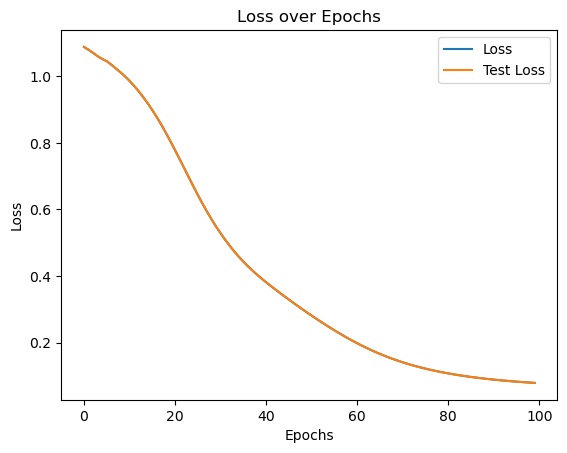

In [7]:
# Visualizing the loss over epochs
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [8]:
# Evaluating the model on the test set
with torch.no_grad(): # turn off backpropagation
    y_eval = model.forward(X_test) # Forward pass on the test set
    _, predicted = torch.max(y_eval.data, 1) # Get the predicted class labels
    loss = criterion(y_eval, y_test) # Compute the loss on the test set
    print(f'Test Loss: {loss}')

correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1}: {str(y_val)} {y_test[i]}')
        if torch.argmax(y_val) == y_test[i]:
            correct += 1
print(f'Accuracy: {correct}/{len(X_test)} = {correct/len(X_test)}')

Test Loss: 0.07315991818904877
1: tensor([1.8596, 8.6829, 6.0480]) 1
2: tensor([ 11.7847,   6.2617, -15.8514]) 0
3: tensor([-4.0239, 12.0519, 21.4590]) 2
4: tensor([1.6434, 8.7708, 6.5691]) 1
5: tensor([2.1041, 9.4800, 6.5846]) 1
6: tensor([ 11.1117,   5.9415, -14.9749]) 0
7: tensor([3.6889, 7.8427, 1.5168]) 1
8: tensor([-0.1226, 10.4865, 12.0799]) 2
9: tensor([0.8714, 9.0440, 8.3792]) 1
10: tensor([3.1887, 8.0834, 2.7695]) 1
11: tensor([ 0.1858,  9.8697, 10.7189]) 2
12: tensor([ 10.3826,   5.5947, -14.0253]) 0
13: tensor([ 11.9406,   6.3359, -16.0546]) 0
14: tensor([ 10.4750,   5.6387, -14.1457]) 0
15: tensor([ 11.2382,   6.0017, -15.1397]) 0
16: tensor([1.9406, 9.1351, 6.4621]) 1
17: tensor([-2.2278, 10.4134, 15.9880]) 2
18: tensor([2.8538, 7.8613, 3.1269]) 1
19: tensor([1.5557, 8.3593, 6.2188]) 1
20: tensor([-2.1900, 10.2713, 15.7377]) 2
21: tensor([ 10.0044,   5.4148, -13.5327]) 0
22: tensor([0.2849, 9.3001, 9.8153]) 2
23: tensor([ 10.3810,   5.5940, -14.0233]) 0
24: tensor([-1.956